In [1]:
import numpy as np
import matplotlib.pyplot as plt
import io

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.distributions as TD

import os
import sys
from tqdm.notebook import tqdm

if torch.cuda.is_available():
    DEVICE = 'cuda'
    GPU_DEVICE = 0
    torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'
DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

<!-- <center><img src="data:image/png;base64," width=500 /></center> -->

# <center>Deep Generative Models</center>
## <center>Seminar 4</center>

<center>07.10.2025</center>


## Plan

1. Latent Variable Modeling

    - Gaussian Mixture Models (GMM)
    
    - MLE for GMM
    
2. ELBO and EM - algorithm. 
    
    - EM algorithms for GMM (theory and practice)
    

## Latent Variables Model

What do you remember about it?

<center>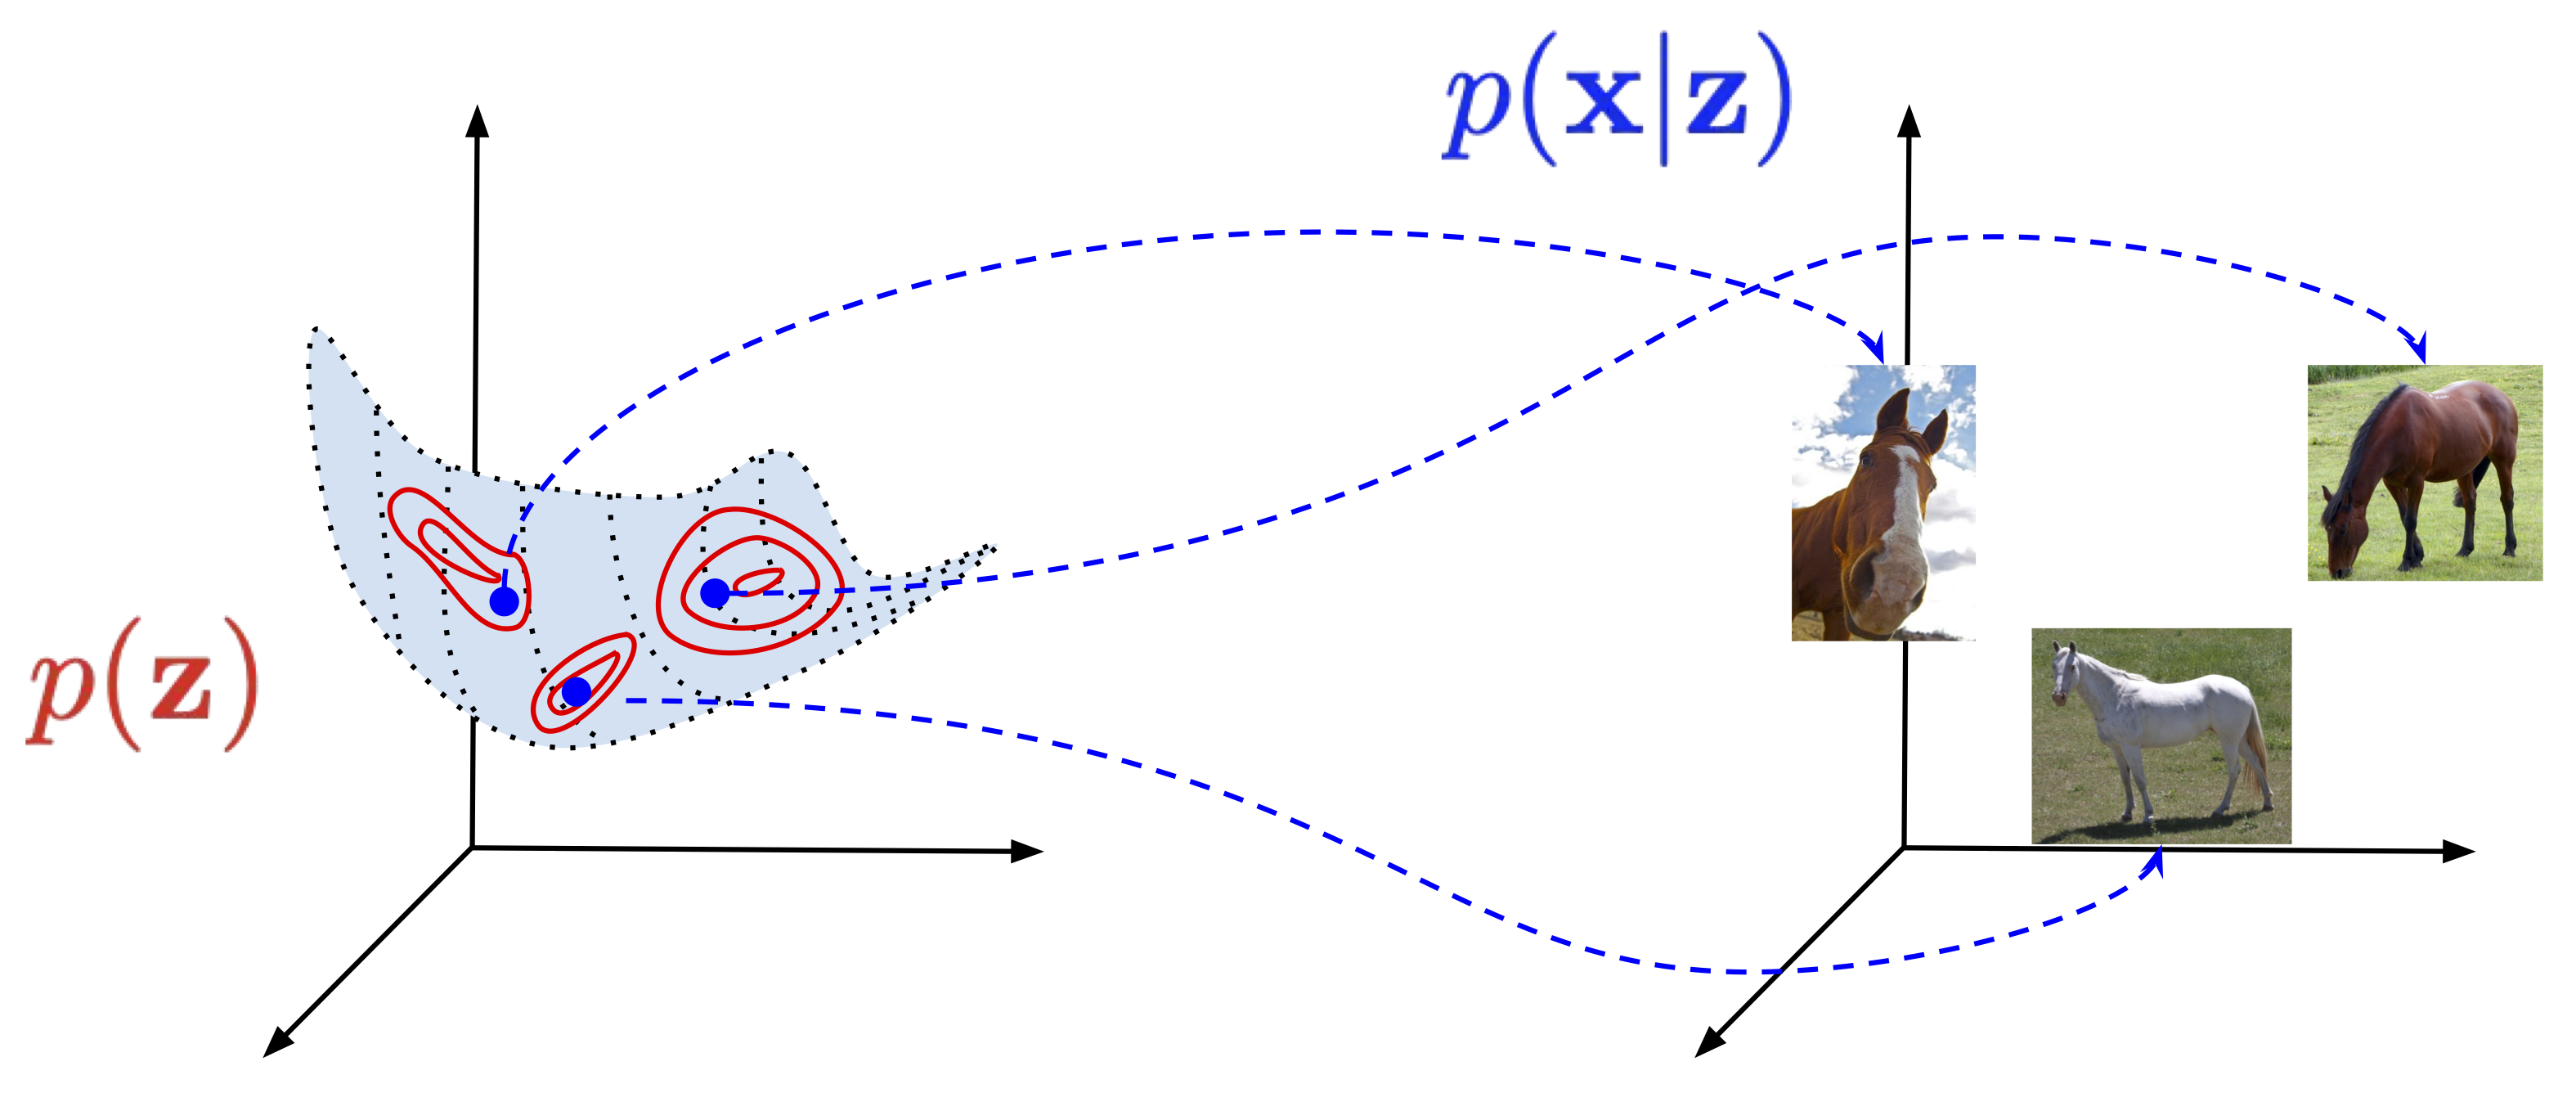</center>

**Likelihood**

$p(x |\theta) = \int\limits_{\mathcal{Z}} p(x | z, \theta) p(z| \theta) dz$

**Sampling procedure**

* Sample $z^* \sim p(z | \theta)$

* Sample $x \sim p(x | z^*, \theta)$

**Question** 

$p(x) = \int p(x|z)p(z)dz = \mathbb{E}_{z\sim p(z)} p(x|z) \approx \dfrac{1}{K}\sum_k p(x|z_k)$. 

Problems?

### Gaussian Mixture Models

$p(z | \theta) = \text{Categorical}(\pi_1, \dots \pi_K)$

$p(\boldsymbol{x} | z, \theta) = \mathcal{N}\left(\boldsymbol{x}|, \boldsymbol{\mu}_z, \boldsymbol{\Sigma}_z\right)$

**Likelihood** of the model?

$p(x | \theta) = \sum\limits_{k = 1}^{K}  \pi_k \mathcal{N}\left(x | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k\right)$

Loading `dgm_utils` for colab users

In [3]:
# colab dgm_utils install
COMMIT_HASH = "f248183c31ac030c81031ae2d2f1a1c42e3a197b"
!if [ -d dgm_utils ]; then rm -Rf dgm_utils; fi
!git clone https://github.com/r-isachenko/dgm_utils.git
%cd dgm_utils
!git checkout {COMMIT_HASH}
!pip install ./
%cd ./..
!rm -Rf dgm_utils

Cloning into 'dgm_utils'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 134 (delta 83), reused 89 (delta 43), pack-reused 0 (from 0)
Receiving objects: 100% (134/134), 26.47 KiB | 511.00 KiB/s, done.
Resolving deltas: 100% (83/83), done.
/Users/matvey/matveymor/DGM/seminar4/dgm_utils
Note: switching to 'f248183c31ac030c81031ae2d2f1a1c42e3a197b'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at f248183 Merge

Loading `dgm_utils` from local

In [4]:
from dgm_utils import train_model, plot_training_curves, show_samples
from dgm_utils import visualize_2d_samples, visualize_2d_densities, visualize_2d_data

**Note:** Можно создавать параметры модели следующим образом!: 

```python
self.param = nn.Parameter(param)
```

Поскольку  `__setattr__` переопредлён!

In [5]:
class GMM(nn.Module):
    @property
    def mu(self):
        return self._mu
    
    @mu.setter
    def mu(self, val):
        self._mu = nn.Parameter(val)

    @property
    def sigma(self):
        # The covariance matrix is a positive definite matrix
        return self._L @ self._L.transpose(1, 2)
    
    @sigma.setter
    def sigma(self, val):
        self._L = nn.Parameter(torch.cholesky(val))

    @property
    def pi(self):
        return F.softmax(self._log_pi)

    @pi.setter
    def pi(self, val):
        assert val.min() > 0.
        val = val/torch.sum(val)
        self._log_pi = nn.Parameter(torch.log(val))

    @property
    def gmm(self):
        # Computational graph issues
        mix = TD.Categorical(self.pi)
        mv_normals = TD.MultivariateNormal(self.mu, scale_tril=self._L)
        gmm = TD.MixtureSameFamily(mix, mv_normals)
        return gmm

    def __init__(self, K, dim, mu=None, sigma=None, pi=None):
        '''
        Define a model with known number of clusters and dimensions.
        :Parameters:
            - K: Number of Gaussian clusters
            - dim: Dimension 
            - mu: means of clusters (K, dim)
                       (default) random from uniform[-10, 10]
            - sigma: covariance matrices of clusters (K, dim, dim)
                          (default) Identity matrix for each cluster
            - pi: cluster weights (K,)
                       (default) equal value to all cluster i.e. 1/K
        '''
        super().__init__()
        self.K = K
        self.dim = dim
        if mu is None:
            mu = np.random.rand(K, dim)*20 - 10
        self.mu = torch.tensor(mu) # (K, D)
        if sigma is None :
            sigma = np.zeros((K, dim, dim))
            for i in range(K):
                sigma[i] = np.eye(dim)
        self.sigma = torch.tensor(sigma) # (K, D, D)
        assert torch.allclose(self.sigma, torch.tensor(sigma))
        if pi is None:
            pi = np.ones(self.K)/self.K
        self.pi = torch.tensor(pi) # (K,)

    def log_prob(self, X):
        '''
        Compute the log-prob of each element in X
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of each element in X: log Sum_k pi_k * N( X_i | mu_k, sigma_k ))
        '''
        return self.gmm.log_prob(X)

    def prob(self, X):
        '''
        Computes the prob of each element in X
        input:
            - X: Data (batch_size, dim)
        output:
            - log-likelihood of each element in X: Sum_k pi_k * N( X_i | mu_k, sigma_k )
        '''
        return torch.exp(self.log_prob(X))
    
    def prob_X_Zs(self, X):
        '''
        Computes the matrix of probabilities p(X, Z | \theta)
        for all possible Z_i \in \{1, 2, \dots K\}
        :Parameters:
        X : tensor (N, D)
        :Output:
        out : tensor (N, K)
        
        P_ik = p(X_i, z=k) = p(X_i|z=k) * p(z=k) = N(X_i| mu_k, sigma_k) * pi_k
        '''
        mv_normals = self.gmm._component_distribution
        X_expanded = X.unsqueeze(-2).repeat(1, self.K, 1) # (N, K, 2)
        log_probs_unw = mv_normals.log_prob(X_expanded) # (N, K)
        log_probs_w = torch.exp(log_probs_unw) * self.pi.unsqueeze(0) # (N, K)
        return log_probs_w

    def sample(self, shape):
        return self.gmm.sample(shape)

GMM visualization

In [6]:
def draw_contour(density, X, Y, title, n_levels=3):
    plt.figure(figsize=(5, 5))
    density = density.reshape(X.shape)
    levels = np.linspace(np.min(density), np.max(density), n_levels)
    plt.contour(X, Y, density, levels=levels, c='red')
    plt.title(title, fontsize=16)
    plt.show()

def draw_distrib(distrib, title, n_levels=20, x_lim=(-11, 11), y_lim=(-11, 11), dx=0.1, dy=0.1, device=DEVICE, contour=True, density=True):
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    mesh_xs = np.stack([x, y], axis=2).reshape(-1, 2)
    densities = torch.exp(distrib.log_prob(torch.tensor(mesh_xs).to(device))).detach().cpu().numpy()
    if contour:
        draw_contour(densities, x, y, title='{} contour'.format(title), n_levels=20)
    if density:
        visualize_2d_densities(x, y, densities, title='{} pdf'.format(title))

#### Task setup

The distribution we will work with:

In [7]:
class FlowerGMM(GMM):
    def __init__(self):
        CENTERS_SCALE = 6.
        MAJOR_VAR = 3.
        MINOR_VAR = 1.
        r_angles = np.linspace(0., 2 * np.pi, 7, endpoint=False)
        vs = np.array([[np.cos(ang), np.sin(ang)] for ang in r_angles])
        perp_vs = np.array([[-np.sin(ang), np.cos(ang)] for ang in r_angles])
        mus = np.array([[0., 0.],] + [CENTERS_SCALE * v for v in vs])
        R_matrices = np.stack([vs, perp_vs], axis=1)
        petal_sigmas = np.array([[MAJOR_VAR, 0.], [0., MINOR_VAR]])[np.newaxis,...].repeat(7, axis=0)
        sigmas = np.concatenate([
            np.eye(2)[np.newaxis,...], 
            R_matrices.transpose(0, 2, 1) @ petal_sigmas @ R_matrices])
        super().__init__(8, 2, mu=mus, sigma=sigmas)
        # super().__init__(1, 2)

Visualization of `FlowerGMM`

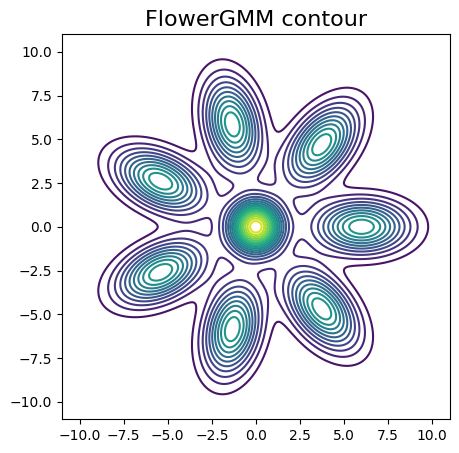

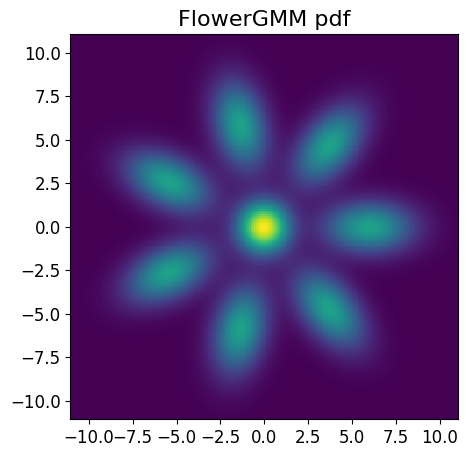

In [8]:
fgmm = FlowerGMM().to(DEVICE)
draw_distrib(fgmm, 'FlowerGMM')

Reference samples from `FlowerGMM`

In [9]:
torch.manual_seed(42)
train_data = fgmm.sample((20000,)).detach()
test_data = fgmm.sample((2000,)).detach()

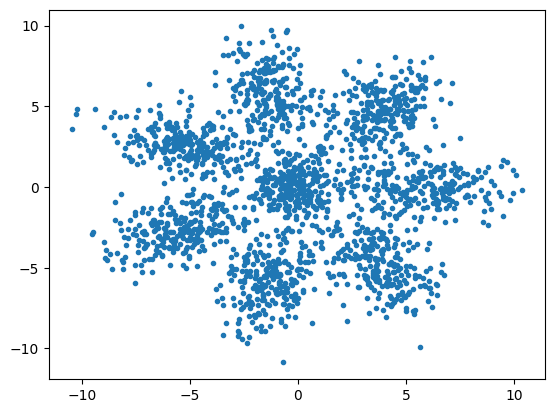

In [10]:
plt.scatter(test_data[:,0], test_data[:,1], marker='.')

**Question.**

How to fit GMM model to data $X_1, \dots X_n$ from unknown distribution?

- One can try likelihood maximization

- EM algorithm (will be explained soon)

### GMM via MLE

Let $X_1, \dots, X_N \sim p(x)$ , $X_i \in \mathbb{R}^D$

**GMM** model likelihood: 

$\log p(\boldsymbol{X} | \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \sum\limits_{n = 1}^{N} \log \left(\sum\limits_{k = 1}^{K}  \pi_k \mathcal{N}\big{(}X_n - \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k\big{)}\right)$

Analytical solution is **hard**! $\Rightarrow$ gradient optimization

In [11]:
class GMM_MLEgrad(GMM):

    def loss(self, x):
        # self._project()
        nll = - self.log_prob(x)
        total_loss = nll.mean()
        return {'total_loss': total_loss}

Initialize a GMM model which will be trained

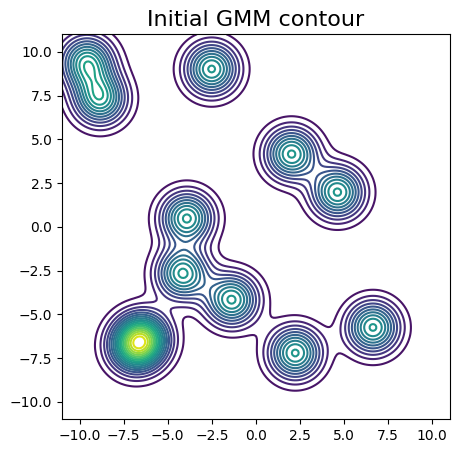

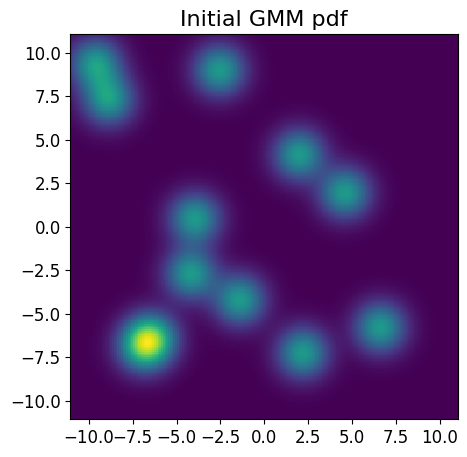

In [12]:
np.random.seed(42)
N_COMPONENTS = 12
gmm = GMM_MLEgrad(N_COMPONENTS, 2).to(DEVICE)
draw_distrib(gmm, 'Initial GMM')

Start of the training


Training epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 1:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 1, loss: 7.502636513697072


Training epoch 2:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 2:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 2, loss: 6.817223341466725


Training epoch 3:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 3:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 3, loss: 6.437291268225832


Training epoch 4:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 4:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 4, loss: 6.19305234353129


Training epoch 5:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 5:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 5, loss: 6.029696069352883


Training epoch 6:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 6:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 6, loss: 5.911869440250251


Training epoch 7:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 7:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 7, loss: 5.822581790124843


Training epoch 8:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 8:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 8, loss: 5.753450645771533


Training epoch 9:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 9:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 9, loss: 5.698238684359366


Training epoch 10:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 10:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 10, loss: 5.65482871581073


Training epoch 11:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 11:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 11, loss: 5.6167547591730544


Training epoch 12:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 12:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 12, loss: 5.58637045853563


Training epoch 13:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 13:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 13, loss: 5.559040335732373


Training epoch 14:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 14:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 14, loss: 5.53524789461913


Training epoch 15:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 15:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 15, loss: 5.513254087198519


Training epoch 16:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 16:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 16, loss: 5.494223939917355


Training epoch 17:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 17:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 17, loss: 5.4755840820300605


Training epoch 18:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 18:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 18, loss: 5.458215239634781


Training epoch 19:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 19:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 19, loss: 5.442501240902937


Training epoch 20:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 20:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 20, loss: 5.428820597536776


Training epoch 21:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 21:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 21, loss: 5.414557255977735


Training epoch 22:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 22:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 22, loss: 5.4026036419519405


Training epoch 23:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 23:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 23, loss: 5.39252155753657


Training epoch 24:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 24:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 24, loss: 5.383113530856527


Training epoch 25:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 25:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 25, loss: 5.3778197083779755


Training epoch 26:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 26:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 26, loss: 5.372015255260739


Training epoch 27:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 27:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 27, loss: 5.365946397367417


Training epoch 28:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 28:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 28, loss: 5.363276513798102


Training epoch 29:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 29:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 29, loss: 5.3604172787715925


Training epoch 30:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 30:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 30, loss: 5.3573596472337135


Training epoch 31:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 31:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 31, loss: 5.356353406696365


Training epoch 32:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 32:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 32, loss: 5.35461933890952


Training epoch 33:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 33:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 33, loss: 5.352721048615962


Training epoch 34:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 34:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 34, loss: 5.352059052064986


Training epoch 35:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 35:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 35, loss: 5.351762048827397


Training epoch 36:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 36:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 36, loss: 5.349955602475377


Training epoch 37:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 37:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 37, loss: 5.348823194371075


Training epoch 38:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 38:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 38, loss: 5.348529981348453


Training epoch 39:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 39:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 39, loss: 5.347713464876768


Training epoch 40:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 40:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 40, loss: 5.347804200740564


Training epoch 41:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 41:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 41, loss: 5.346829473649191


Training epoch 42:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 42:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 42, loss: 5.345748744737422


Training epoch 43:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 43:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 43, loss: 5.345655443322841


Training epoch 44:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 44:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 44, loss: 5.345403746998525


Training epoch 45:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 45:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 45, loss: 5.344790440393905


Training epoch 46:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 46:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 46, loss: 5.343901643151412


Training epoch 47:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 47:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 47, loss: 5.3426236100511995


Training epoch 48:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 48:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 48, loss: 5.342390026176362


Training epoch 49:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 49:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 49, loss: 5.341582599480143


Training epoch 50:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 50:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 50, loss: 5.340550896665052


Training epoch 51:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 51:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 51, loss: 5.340530558647929


Training epoch 52:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 52:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 52, loss: 5.340663417586679


Training epoch 53:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 53:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 53, loss: 5.339451099773547


Training epoch 54:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 54:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 54, loss: 5.340471121379288


Training epoch 55:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 55:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 55, loss: 5.338940169040643


Training epoch 56:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 56:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 56, loss: 5.339943733183473


Training epoch 57:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 57:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 57, loss: 5.338407427424263


Training epoch 58:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 58:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 58, loss: 5.337453632296174


Training epoch 59:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 59:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 59, loss: 5.335970499307601


Training epoch 60:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 60:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 60, loss: 5.335814299619165


Training epoch 61:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 61:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 61, loss: 5.335412363322527


Training epoch 62:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 62:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 62, loss: 5.334526791123038


Training epoch 63:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 63:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 63, loss: 5.334764601835765


Training epoch 64:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 64:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 64, loss: 5.333480037404352


Training epoch 65:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 65:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 65, loss: 5.332723630599536


Training epoch 66:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 66:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 66, loss: 5.334044684224266


Training epoch 67:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 67:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 67, loss: 5.331983445923088


Training epoch 68:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 68:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 68, loss: 5.331043578920987


Training epoch 69:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 69:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 69, loss: 5.331091398300783


Training epoch 70:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 70:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 70, loss: 5.330780835627189


Training epoch 71:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 71:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 71, loss: 5.329843992822846


Training epoch 72:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 72:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 72, loss: 5.329049502372721


Training epoch 73:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 73:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 73, loss: 5.328337089435279


Training epoch 74:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 74:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 74, loss: 5.32657245421937


Training epoch 75:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 75:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 75, loss: 5.3271731584214415


Training epoch 76:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 76:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 76, loss: 5.325631372020137


Training epoch 77:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 77:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 77, loss: 5.325086971938718


Training epoch 78:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 78:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 78, loss: 5.324737048197378


Training epoch 79:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 79:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 79, loss: 5.323696312759445


Training epoch 80:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 80:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 80, loss: 5.324093885597513


Training epoch 81:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 81:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 81, loss: 5.322887517926163


Training epoch 82:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 82:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 82, loss: 5.322020649004451


Training epoch 83:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 83:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 83, loss: 5.322584512832618


Training epoch 84:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 84:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 84, loss: 5.321206205136731


Training epoch 85:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 85:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 85, loss: 5.321001223645368


Training epoch 86:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 86:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 86, loss: 5.319665625139674


Training epoch 87:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 87:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 87, loss: 5.319994888529962


Training epoch 88:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 88:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 88, loss: 5.3188968506744265


Training epoch 89:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 89:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 89, loss: 5.318515398781056


Training epoch 90:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 90:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 90, loss: 5.317722644658009


Training epoch 91:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 91:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 91, loss: 5.3177044990762585


Training epoch 92:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 92:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 92, loss: 5.317285522863043


Training epoch 93:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 93:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 93, loss: 5.317779111252974


Training epoch 94:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 94:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 94, loss: 5.316942928590867


Training epoch 95:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 95:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 95, loss: 5.316407716258996


Training epoch 96:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 96:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 96, loss: 5.316941640572013


Training epoch 97:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 97:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 97, loss: 5.315313752055499


Training epoch 98:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 98:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 98, loss: 5.3155028997264235


Training epoch 99:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 99:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 99, loss: 5.3151647477095105


Training epoch 100:   0%|          | 0/157 [00:00<?, ?it/s]

Evaluating epoch 100:   0%|          | 0/16 [00:00<?, ?it/s]

Epoch: 100, loss: 5.315541869065059


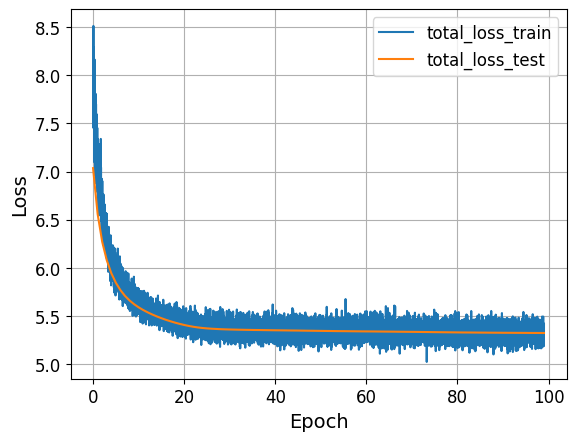

End of the training


In [13]:
BATCH_SIZE = 128
LR= 1e-3
EPOCHS = 100
USE_CUDA=False

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

optimizer = optim.Adam(gmm.parameters(), lr=LR)

train_model(
    gmm, 
    train_loader, 
    test_loader, 
    epochs=EPOCHS, 
    optimizer=optimizer,
    scheduler=None, 
    device=DEVICE,
    visualize_samples=False
)

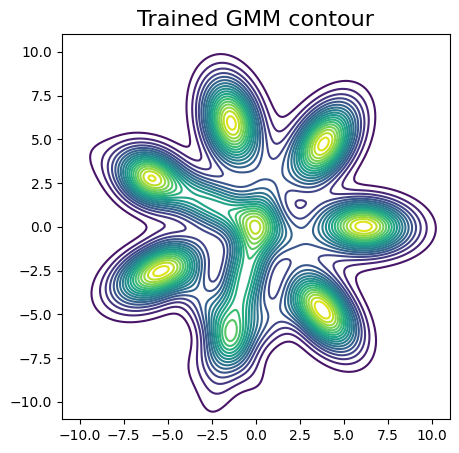

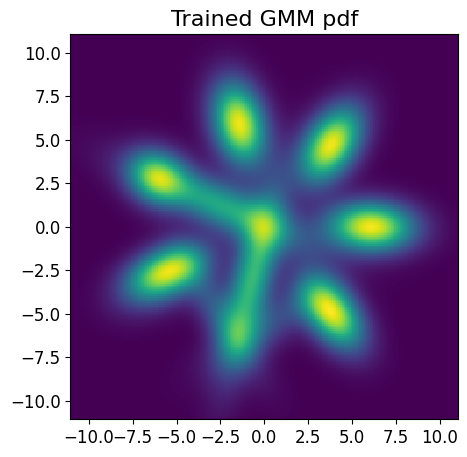

In [15]:
draw_distrib(gmm, 'Trained GMM')

## ELBO

<center>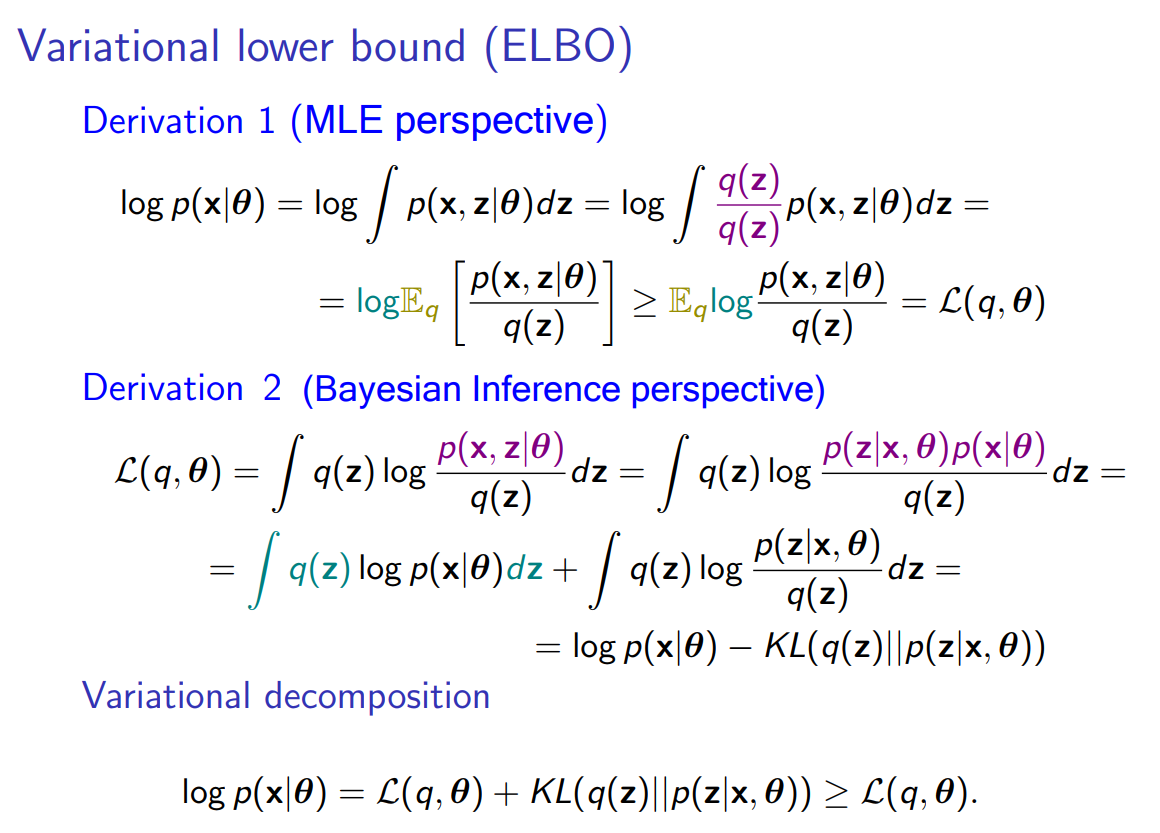</center>

## EM-algorithm

<center>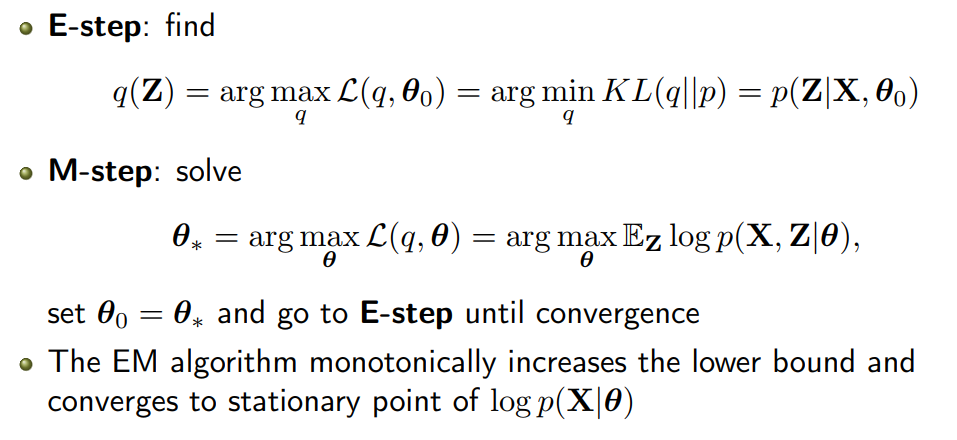</center>

### GMM via EM - algorithm

# EM Algorithm for Gaussian Mixture Models

## Model Parameters
$\theta = \{ \boldsymbol{\pi}_{1:K}, \boldsymbol{\mu}_{1:K}, \boldsymbol{\Sigma}_{1:K} \}$, where:
- $\boldsymbol{\pi}_{1:K}$ are the mixture weights (positive values that sum to 1)
- $\boldsymbol{\mu}_{1:K}$ are the mean vectors for each component
- $\boldsymbol{\Sigma}_{1:K}$ are the covariance matrices for each component

## EM Algorithm Iteration

### E-step (Expectation)
Calculate the posterior probabilities (responsibilities) that component $k$ generated observation $\mathbf{x}_n$:

$$\xi_{k}^{n} = p\left( z_n = k \middle| \mathbf{x}_n, \theta^{\text{prev}}\right) = \frac{\pi_k^{\text{prev}} \mathcal{N}\left(\mathbf{x}_n \middle| \boldsymbol{\mu}_k^{\text{prev}}, \boldsymbol{\Sigma}_k^{\text{prev}}\right)}{\sum\limits_{k' = 1}^{K} \pi_{k'}^{\text{prev}} \mathcal{N}\left(\mathbf{x}_n \middle| \boldsymbol{\mu}_{k'}^{\text{prev}}, \boldsymbol{\Sigma}_{k'}^{\text{prev}}\right)}$$

Where:
- $\xi_{k}^{n}$ represents the responsibility of component $k$ for explaining observation $\mathbf{x}_n$
- $\mathcal{N}\left(\mathbf{x}_n \middle| \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k\right)$ is the probability density of the multivariate normal distribution
- The denominator ensures that $\sum_{k=1}^{K} \xi_{k}^{n} = 1$ for each observation $n$

### M-step (Maximization)
Update the model parameters using the calculated responsibilities:

1. **Update mixture weights**:
   $$\pi_k^{\text{new}} = \frac{1}{N} \sum\limits_{n = 1}^{N} \xi_k^n \, \in \, (0, 1)$$
   
   This represents the average responsibility of component $k$ across all observations.
   Note that $\sum_{k=1}^{K} \pi_k^{\text{new}} = 1$ since $\sum_{k=1}^{K} \xi_k^n = 1$ for any $n$.

2. **Update component means**:
   $$\boldsymbol{\mu}_k^{\text{new}} = \frac{\sum\limits_{n = 1}^{N} \xi_{k}^{n} \mathbf{x}_n}{\sum\limits_{n = 1}^{N} \xi_k^n} \, \in \, \mathbb{R}^D$$
   
   This is the weighted average of all observations, where the weights are the responsibilities.
   The denominator $\sum_{n=1}^{N} \xi_k^n$ represents the effective number of points assigned to component $k$.

3. **Update component covariance matrices**:
   $$\boldsymbol{\Sigma}_k^{\text{new}} = \frac{\sum\limits_{n = 1}^{N} \xi_{k}^{n} \left(\mathbf{x}_n - \boldsymbol{\mu}_k^{\text{new}}\right) \left(\mathbf{x}_n - \boldsymbol{\mu}_k^{\text{new}}\right)^T}{\sum\limits_{n = 1}^{N} \xi_k^n} \in \text{PSD}\left(\mathbb{R}^{D \times D}\right)$$
   
   This is the weighted sample covariance matrix relative to the updated mean.
   PSD denotes that the resulting matrix belongs to the set of positive semi-definite matrices.

## Algorithm Flow
1. Initialize parameters $\theta^{(0)}$ (often using random initialization or K-means)
2. Iterate until convergence:
   - Perform E-step: compute responsibilities $\xi_{k}^{n}$ using current parameters
   - Perform M-step: update parameters $\theta^{\text{new}}$ using computed responsibilities
   - Check convergence criterion (e.g., change in log-likelihood below threshold)
3. Return final parameter estimates $\theta^{\text{final}}$

In [16]:
# K is number of components in the Gaussian Mixture Model
# N is the number of samples |X|
# D=2 is the dimension of each sample X_n

class GMM_EM(GMM):
    
    def prob_components(self, X):
        '''
        Creates matrix of p(z_k | X_n, \theta)
        :Parameters:
        X : tensor (N, 2) : samples from the target distribution
        '''
        p_x_zs = self.prob_X_Zs(X) # (N, K)
        return p_x_zs / p_x_zs.sum(-1, keepdim=True) # (N, K)
    
    def compute_pi_new(self, prob_components):
        '''
        Computes the paramters \pi_{new} at the M-step of EM algo
        :Parameters:
        prob_components : tensor (N, K) : p(z_k | X_n, \theta_{\old}) matrix
        :Output:
        pi_new : tensor (K,) : \pi_{new} 
        '''
        return torch.mean(prob_components, dim=0)
    
    def compute_mu_new(self, X, prob_components):
        '''
        Computes the parameters \mu_{new} at the M-step of EM algo
        :Paramters:
        X : tensor (N, 2) : samples from the target distribution
        prob_components : tensor (N, K) : p(z_k | X_n, \theta_{\old}) matrix
        :Output:
        mu_new : tensor (K, 2) : \mu_{new}
        '''
        X_expanded = X.unsqueeze(-2) # (N, 1, 2)
        prob_components_expanded = prob_components.unsqueeze(-1) # (N, K, 1)
        mu_unnorm = torch.sum(X_expanded * prob_components_expanded, dim=0) # (K, 2)
        return mu_unnorm / prob_components_expanded.sum(0)
    
    def compute_sigma_new(self, X, mu_new, prob_components):
        '''
        :Parameters:
        X : tensor (N, 2) : samples from the target distribution
        mu_new : tensor (K, 2) : \mu_{new} from the M-step of EM algo
        prob_components : tensor (N, K) : p(z_k | X_n, \theta_{\old}) matrix
        '''
        X_expanded = X.unsqueeze(-2) # (N, 1, 2)
        mu_new_expanded = mu_new.unsqueeze(0) # (1, K, 2)
        X_min_mu = X_expanded - mu_new_expanded # (N, K, 2)
        X_min_mu_expanded = X_min_mu.unsqueeze(-2) # (N, K, 1, 2)
        Cov_grid = X_min_mu_expanded.transpose(-1, -2) @ X_min_mu_expanded # (N, K, 2, 2)
        prob_components_expanded = prob_components.unsqueeze(-1).unsqueeze(-1) # (N, K, 1, 1)
        Sigma_unnorm = torch.sum(prob_components_expanded * Cov_grid, dim=0) # (K, 2, 2)
        return Sigma_unnorm / prob_components_expanded.sum(0)
    
def EM_step(gmm_em, X):
    gmm_em.eval()
    # E step
    with torch.no_grad():
        prob_components = gmm_em.prob_components(X)
    
    # M step
    with torch.no_grad():
        pi_new = gmm_em.compute_pi_new(prob_components)
        mu_new = gmm_em.compute_mu_new(X, prob_components)
        Sigma_new = gmm_em.compute_sigma_new(X, mu_new, prob_components)
    
    # update parameters
    eps=1e-5
    gmm_em.pi = pi_new 
    gmm_em.mu = mu_new
    # prevent Sigma from being degenerate (make it strictly positive definite)
    Sigma_new += torch.eye(Sigma_new.size(-1)).unsqueeze(0).repeat(Sigma_new.size(0), 1, 1).to(Sigma_new) * eps 
    gmm_em.sigma = Sigma_new

Initialize the gmm distribution to be trained with `EM`-algo

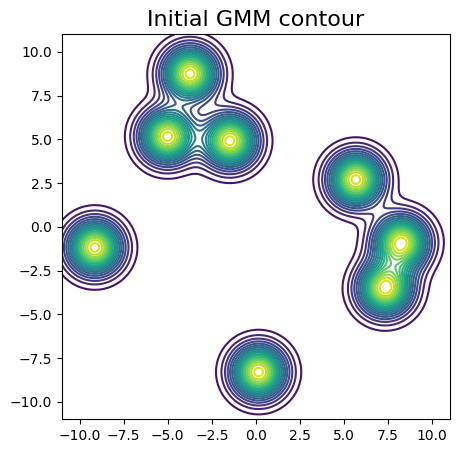

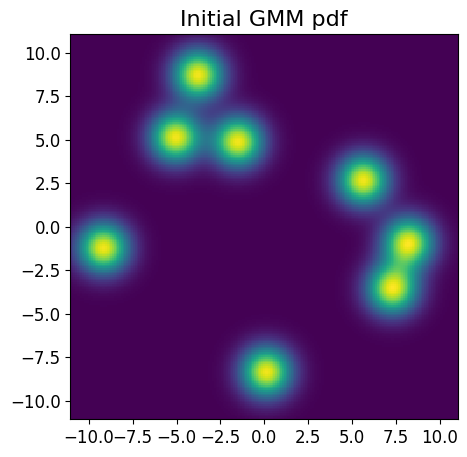

In [17]:
np.random.seed(46)
N_COMPONENTS = 8
gmm = GMM_EM(N_COMPONENTS, 2).to(DEVICE)
draw_distrib(gmm, 'Initial GMM')

Launch the `EM` - algorithm

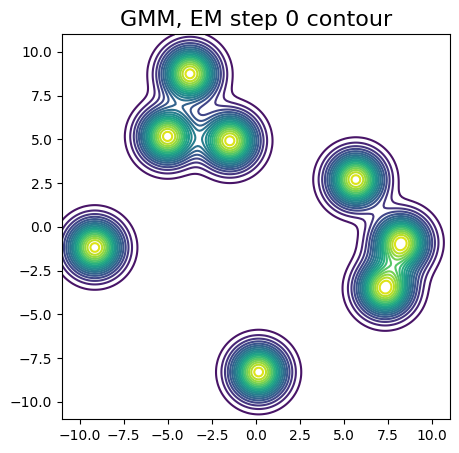

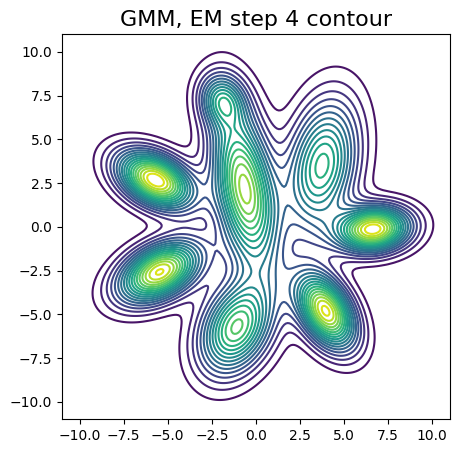

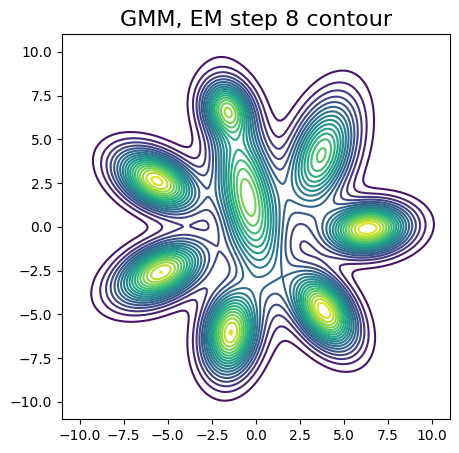

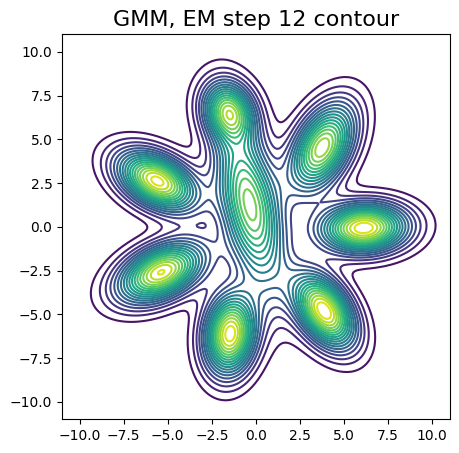

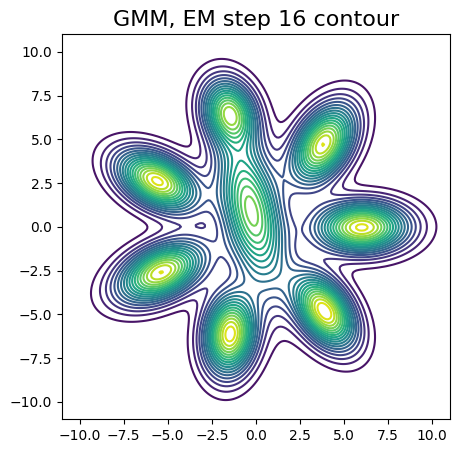

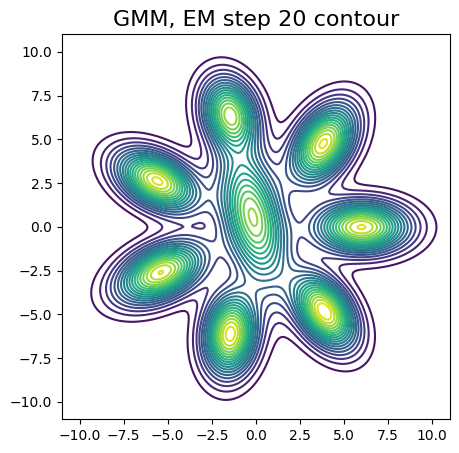

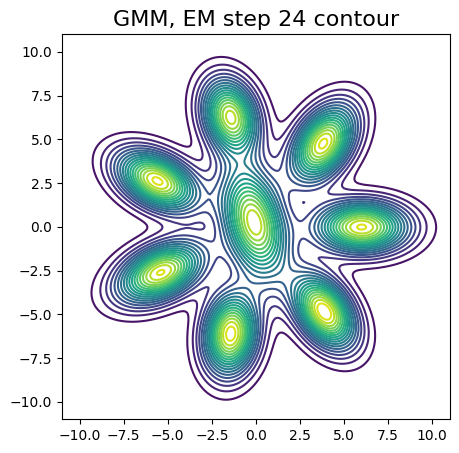

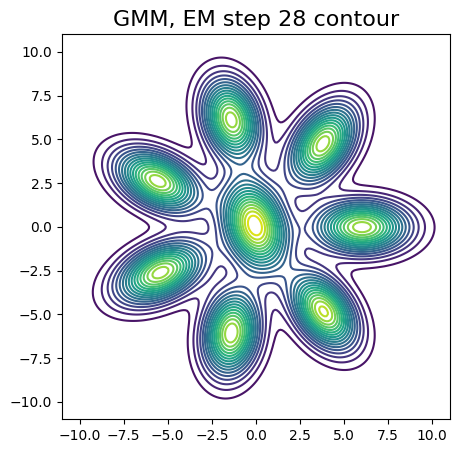

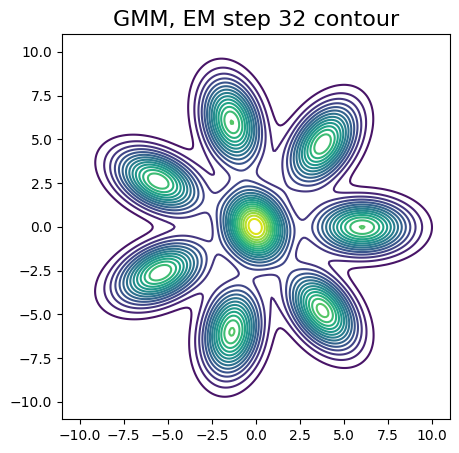

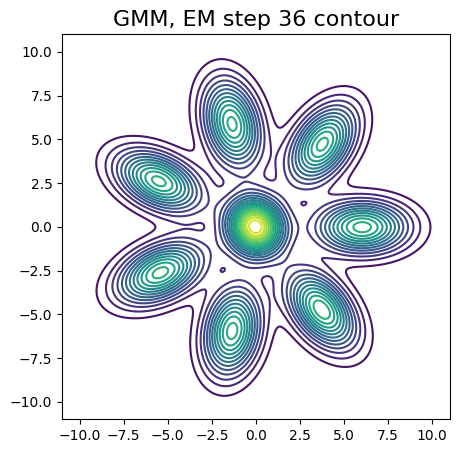

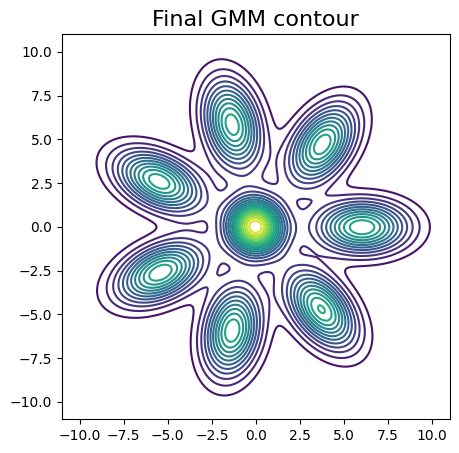

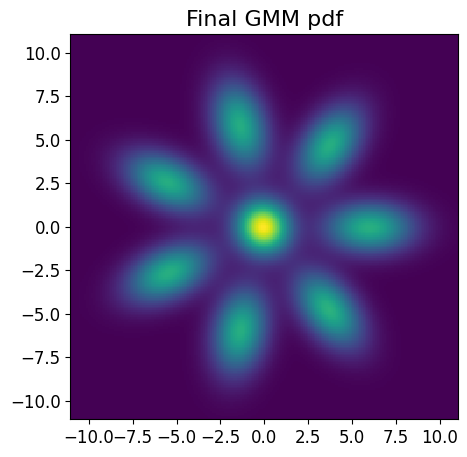

In [18]:
N_EM_STEPS = 40

for n_step in range(N_EM_STEPS):
    if n_step % 4 == 0:
        draw_distrib(gmm, 'GMM, EM step {}'.format(n_step), density=False)
    EM_step(gmm, train_data)
draw_distrib(gmm, 'Final GMM')

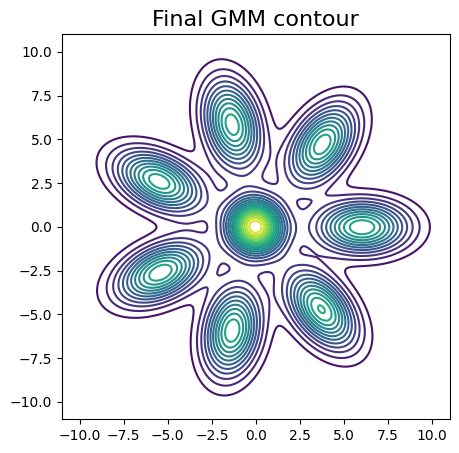

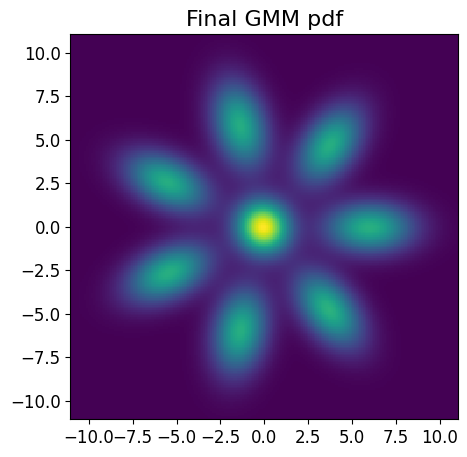

In [19]:
draw_distrib(gmm, 'Final GMM')

### GMM via Variational EM

Let $\boldsymbol{X} = X_1, \dots, X_N$ is samples from unknown distribution

We are looking for the distribution $q(z | x, \phi)$ and $\theta = \{ \boldsymbol{\pi}_{1:K}, \boldsymbol{\mu}_{1:K}, \boldsymbol{\Sigma}_{1:K} \}$ which maximizes the **ELBO** functional:

$$
L(q, \theta) = \int\limits_{\boldsymbol{Z}} q(\boldsymbol{z} | \boldsymbol{X}, \phi) \log \frac{p(\boldsymbol{X}| \boldsymbol{z}, \theta)p(\boldsymbol{z} | \theta)}{q(\boldsymbol{z} | \boldsymbol{X}, \phi)} d \boldsymbol{z} =\\= \sum\limits_{n = 1}^{N} \int\limits_{z_n} q(z_n | X_n, \phi) \log \frac{p(X_n | z_n, \theta) p(z_n | \theta)}{q(z_n | X_n, \phi)} d z_n =\\=
\sum\limits_{n = 1}^{N} \left(\int\limits_{z_n} q(z_n | X_n, \phi) \log p(X_n, z_n | \theta) d z_n - \int\limits_{z_n} q(z_n | X_n, \phi) \log q(z_n | X_n, \phi) d z_n\right) =\\=
\sum\limits_{n = 1}^{N} \Big{(}E_{z_n \sim q(z_n | X_n, \phi)} \log p(X_n, z_n | \theta) + H\big{(}q(z_n | X_n, \phi)\big{)} \Big{)}
$$

**E-step**

$\phi_{k + 1} = \phi_{k} + \eta \nabla_{\phi} L(q(\cdot| \boldsymbol{X}, \phi), \theta_k)|_{\phi=\phi_{k}}$

**M-step**

$\theta_{k + 1} = \theta_{k} + \eta \nabla_{\theta} \sum\limits_{n = 1}^{N} \Big{(}E_{z_n \sim q(z_n | X_n, \phi_{k + 1})} \log p(X_n, z_n | \theta)\Big{)}\Big{|}_{\theta = \theta_{k}}$

**Prerequisites**

Helper function creating generator which cyclically returns `res0` `s0` times and `res1` `s1` times 

In [20]:
def steps_counter(s0, s1, res0='E', res1='M'):
    assert res0 != res1
    curr_step = 0
    steps_passed = 0
    res_mapping = [res0, res1]
    while True:
        steps_passed += 1
        if curr_step == 0:
            if steps_passed > s0:
                curr_step = 1
                steps_passed = 1
        elif curr_step == 1:
            if steps_passed > s1:
                curr_step = 0
                steps_passed = 1
        yield res_mapping[curr_step]

In [21]:
SC = steps_counter(2, 3)
next(SC)

'E'

In [22]:
SC = steps_counter(2, 3)
print([next(SC) for _ in range(10)])

['E', 'E', 'M', 'M', 'M', 'E', 'E', 'M', 'M', 'M']


**Variational EM GMM** implementation

In [23]:
class GMM_VariationalEM(nn.Module):

    @staticmethod
    def freeze(model):
        for p in model.parameters():
            p.requires_grad_(False)
        model.eval()

    @staticmethod
    def unfreeze(model):
        for p in model.parameters():
            p.requires_grad_(True)
        model.train(True)
        
    @property
    def gmm_model(self):
        '''
        returns trained GMM model
        '''
        return self.p_theta

    def __init__(self, K, dim, mu=None, sigma=None, pi=None):
        '''
        Define a model with known number of clusters and dimensions.
        :Parameters:
            - K: Number of Gaussian clusters
            - dim: Dimension 
            - mu: means of clusters (K, dim)
            - sigma: covariance matrices of clusters (K, dim, dim)
            - pi: cluster weights (K,)
        '''
        super().__init__()
        # p_theta is p(x, z | theta)
        self.p_theta = GMM(K, dim, mu, sigma, pi)
        self.q = nn.Sequential(
            nn.Linear(dim, max(100, 2*dim, 2*K)),
            nn.ReLU(True),
            nn.Dropout(0.005),
            nn.Linear(max(100, 2*dim, 2*K), max(100, 4*dim, 4*K)),
            nn.ReLU(True),
            nn.Dropout(0.005),
            nn.Linear(max(100, 4*dim, 4*K), max(100, 2*dim, 2*K)),
            nn.ReLU(True),
            nn.Linear(max(100, 2*dim, 2*K), K),
            nn.Softmax())

    def ELBO_objective(self, X, E_step=False, reduction='sum'):
        '''
        Returns the full ELBO objective
        :Parameters:
        X : tensor (bs, D) : batch of samples
        '''
        eps = 1e-8 # we add eps to stabilize the learning and eliminate nan's 
        assert reduction in ['sum', 'mean']
        def reduction_func(x):
            return torch.sum(x) if reduction == 'sum' else torch.mean(x)
        Z_probs = self.q(X) # (bs, K)
        log_p_x_zs = torch.log(self.p_theta.prob_X_Zs(X) + eps) # (bs, K) p(x, z|\theta)
        elbo_without_entropy_components = torch.sum(Z_probs * log_p_x_zs, dim=-1) # (bs,)

        if not E_step:
            # we don't need entropy on M step
            return reduction_func(elbo_without_entropy_components)

        H_components = torch.sum(-Z_probs * torch.log(Z_probs + eps), dim=-1) # (bs,)
        elbo_components = elbo_without_entropy_components + H_components

        return reduction_func(elbo_components)

    def E_step_loss(self, X):
        #----------------------
        # функции `freeze` и `unfreeze` вызывать не обязательно,
        # они вызываются для примера, как можно уменьшить
        # потребление памяти
        self.freeze(self.p_theta)
        self.unfreeze(self.q)
        # ---------------------
        return - self.ELBO_objective(X, E_step=True, reduction='mean')

    def M_step_loss(self, X):
        #----------------------
        # функции `freeze` и `unfreeze` вызывать не обязательно,
        # они вызываются для примера, как можно уменьшить
        # потребление памяти
        self.freeze(self.q)
        self.unfreeze(self.p_theta)
        # ---------------------
        return - self.ELBO_objective(X, E_step=False, reduction='mean')


def train_GMM_VariationalEM_separate_manner(
    gmmEMVar, 
    train_loader, 
    epochs=20, 
    E_grad_steps = 1,
    M_grad_steps = 1,
    q_lr=1e-3, 
    p_theta_lr=1e-3, 
    use_tqdm=True, 
    use_cuda=False):

    SC = steps_counter(E_grad_steps, M_grad_steps)
    q_optimizer = optim.Adam(gmmEMVar.q.parameters(), lr=q_lr)
    p_theta_optimizer = optim.Adam(gmmEMVar.p_theta.parameters(), lr=p_theta_lr)

    forrange = tqdm(range(epochs)) if use_tqdm else range(epochs)

    if use_cuda:
        gmmEMVar = gmmEMVar.cuda()

    for epoch in forrange:

        if epoch % 4 == 0:
            draw_distrib(gmmEMVar.gmm_model, 'GMM_EM_Var, Separate, epoch {}'.format(epoch), density=False)

        for x in train_loader:
            x = x.float()
            if use_cuda:
                x = x.cuda()
            # EM алгоритм, в котором E и M шаги делаются на разных батчах по отдельности
            # E step
            if next(SC) == 'E':
                q_optimizer.zero_grad()
                E_loss = gmmEMVar.E_step_loss(x)
                E_loss.backward()
                q_optimizer.step()

            # M step
            else:
                p_theta_optimizer.zero_grad()
                M_loss = gmmEMVar.M_step_loss(x)
                M_loss.backward()
                p_theta_optimizer.step()

Initialize the gmm distribution to be trained with `Variational EM`-algo

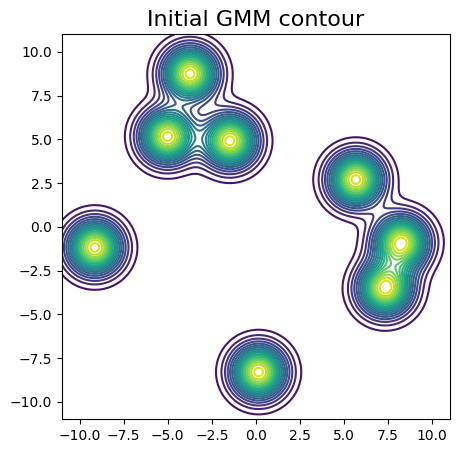

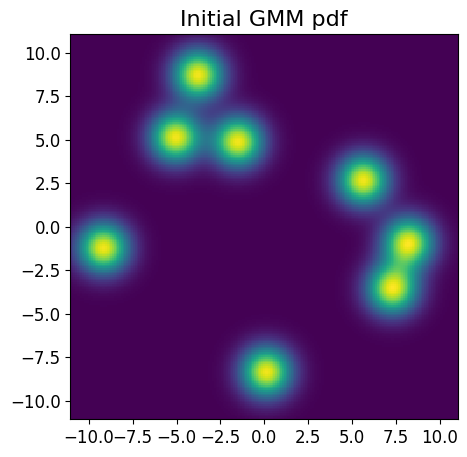

In [24]:
np.random.seed(46)
torch.manual_seed(47)
N_COMPONENTS = 8
gmmEMVar = GMM_VariationalEM(N_COMPONENTS, 2).to(DEVICE)
draw_distrib(gmmEMVar.gmm_model, 'Initial GMM')

Launch the `Variational EM` algo

  0%|          | 0/20 [00:00<?, ?it/s]

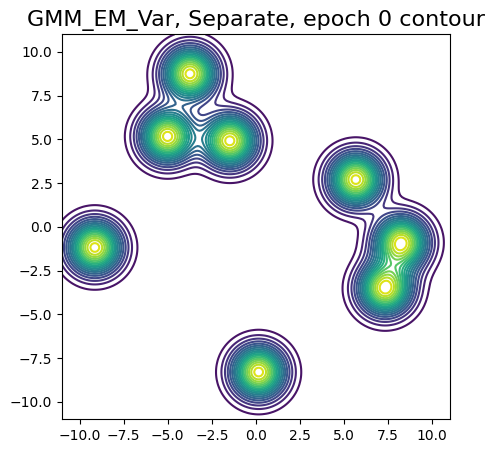

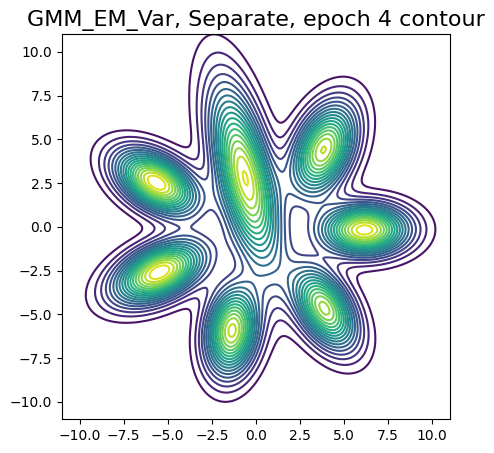

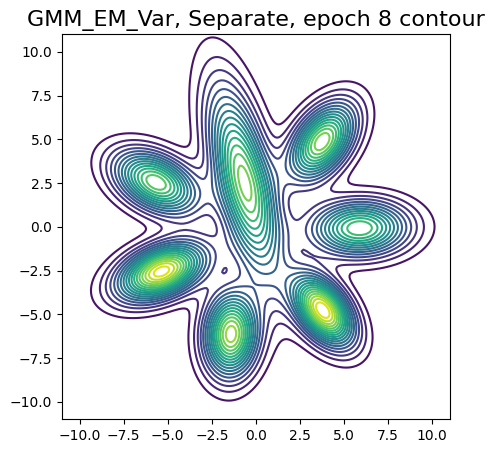

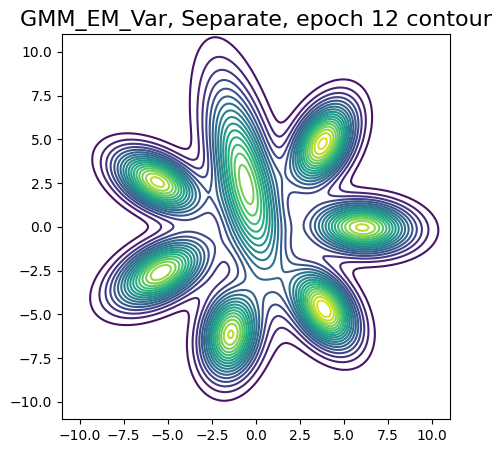

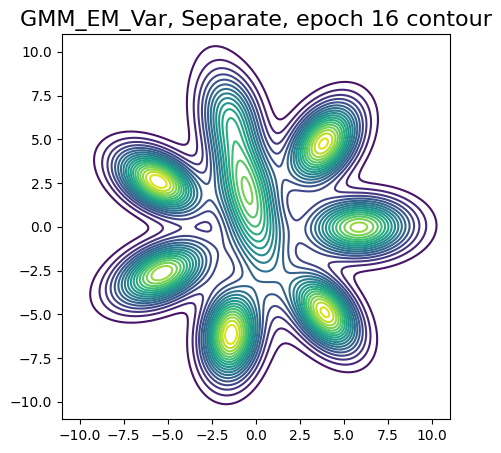

In [25]:
EPOCHS = 20
BATCH_SIZE = 32
Q_LR = 1e-3
P_THETA_LR = 1e-2
E_GRAD_STEPS = 100
M_GRAD_STEPS = 100

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

train_GMM_VariationalEM_separate_manner(
    gmmEMVar, train_loader, EPOCHS, E_GRAD_STEPS, M_GRAD_STEPS, 
    Q_LR, P_THETA_LR, use_tqdm=True, use_cuda=False)

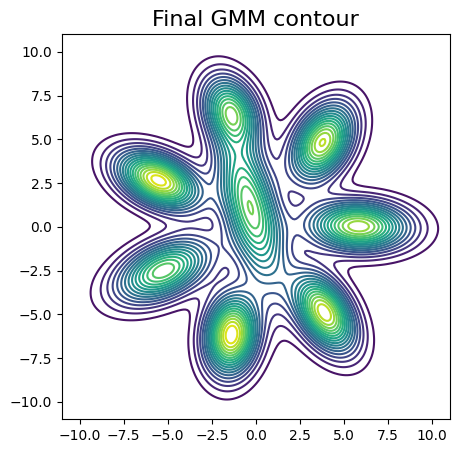

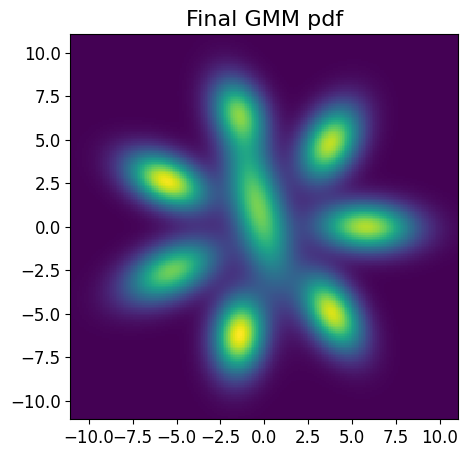

In [26]:
draw_distrib(gmmEMVar.gmm_model, 'Final GMM')

#### Variational EM in a joint manner

Let's do Variational **E-step** and **M-step** via single `backward()` call:

$\phi_{k + 1} = \phi_{k} + \eta \nabla_{\phi} L(q(\cdot| \boldsymbol{X}, \phi), \theta_k)|_{\phi=\phi_{k}}$

$\theta_{k + 1} = \theta_{k} + \eta \nabla_{\theta} L(q(\cdot| \boldsymbol{X}, \color{red}{\phi_{k}}), \theta)|_{\theta=\theta_{k}}$

**Note,** that the gradient step w.r.t. $\theta$ utilizes $\phi = \color{red}{\phi_{k}}$ from the previous step

In [27]:
def train_GMM_VariationalEM_joint_manner(
    gmmEMVar, 
    train_loader, 
    epochs=20,
    q_lr=1e-3, 
    p_theta_lr=1e-3, 
    use_tqdm=True, 
    use_cuda=False):

    q_optimizer = optim.Adam(gmmEMVar.q.parameters(), lr=q_lr)
    p_theta_optimizer = optim.Adam(gmmEMVar.p_theta.parameters(), lr=p_theta_lr)

    forrange = tqdm(range(epochs)) if use_tqdm else range(epochs)

    if use_cuda:
        gmmEMVar = gmmEMVar.cuda()
    
    gmmEMVar.unfreeze(gmmEMVar.p_theta)
    gmmEMVar.unfreeze(gmmEMVar.q)

    for epoch in forrange:

        if epoch % 4 == 0:
            draw_distrib(gmmEMVar.gmm_model, 'GMM_EM_Var, Joint, epoch {}'.format(epoch), density=False)

        for x in train_loader:
            x = x.float()
            if use_cuda:
                x = x.cuda()
            # EM алгоритм, в котором E и M шаги делаются одновременно после единого
            # вызова `.backward()` от ELBO_loss-а
            q_optimizer.zero_grad()
            p_theta_optimizer.zero_grad()
            # Вычисляем полный objective ELBO (как для E шага)
            ELBO_loss = - gmmEMVar.ELBO_objective(x, E_step=True, reduction='mean')
            ELBO_loss.backward()
            
            # E - step
            q_optimizer.step()

            # M step
            p_theta_optimizer.step()

Initialize new `GMM_VariationalEM` model

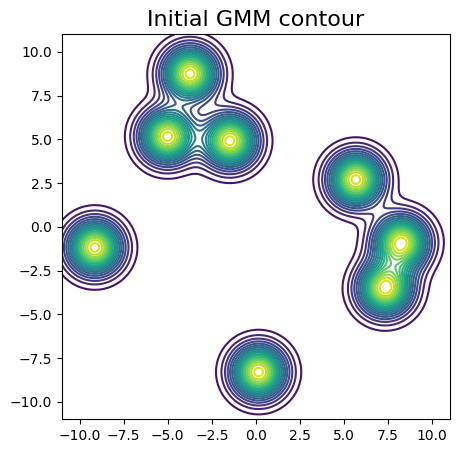

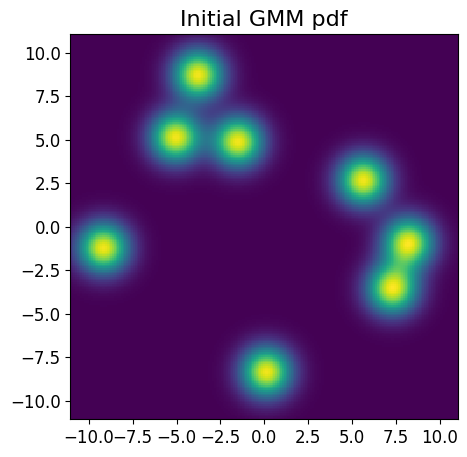

In [28]:
np.random.seed(46)
torch.manual_seed(49)
N_COMPONENTS = 8
gmmEMVar = GMM_VariationalEM(N_COMPONENTS, 2).to(DEVICE)
draw_distrib(gmmEMVar.gmm_model, 'Initial GMM')

Launch the joint `Variational EM` algo:

  0%|          | 0/21 [00:00<?, ?it/s]

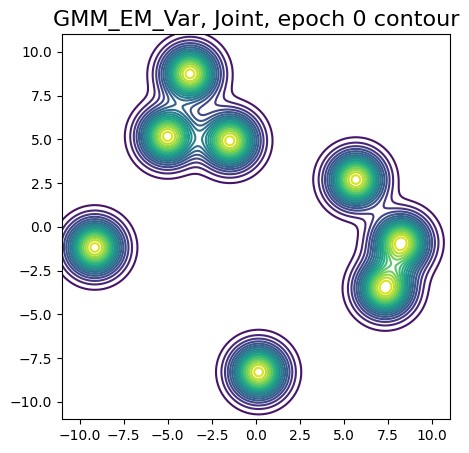

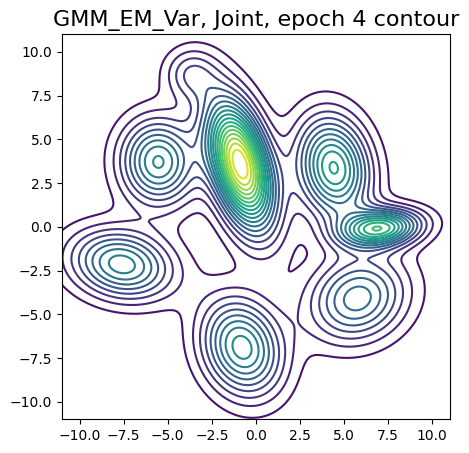

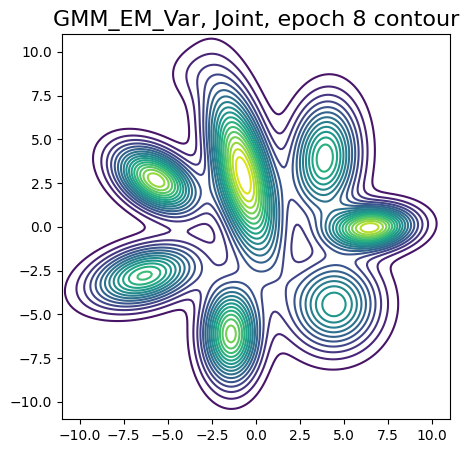

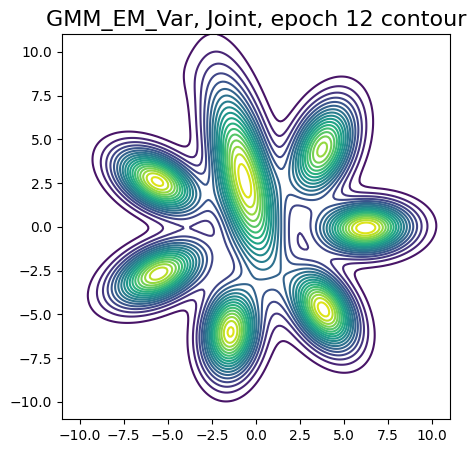

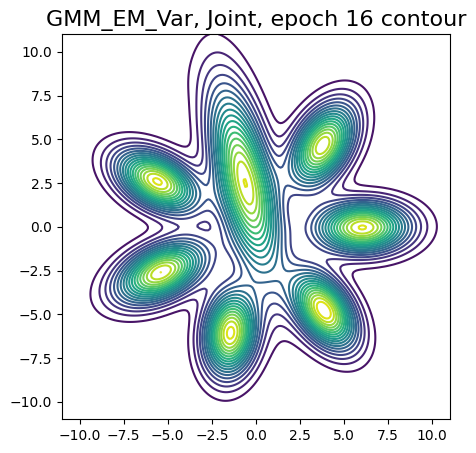

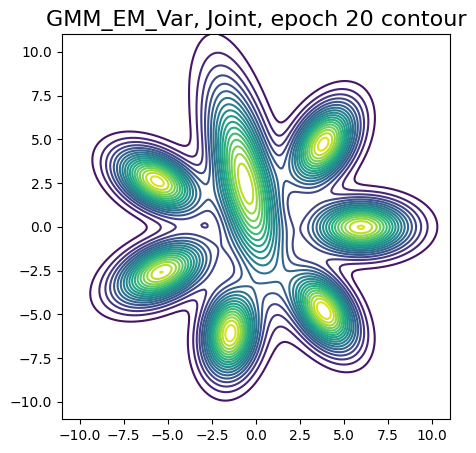

In [29]:
EPOCHS = 21
BATCH_SIZE = 32
Q_LR = 1e-3
GMM_LR = 1e-3

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

train_GMM_VariationalEM_joint_manner(
    gmmEMVar, train_loader, EPOCHS, 
    Q_LR, GMM_LR, use_tqdm=True, use_cuda=False)

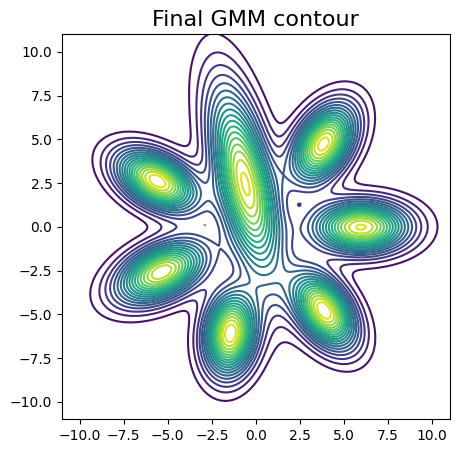

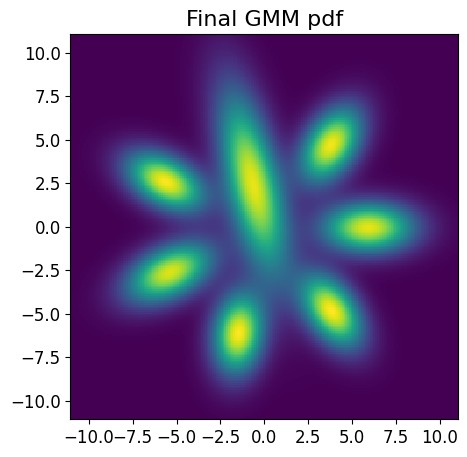

In [30]:
draw_distrib(gmmEMVar.p_theta, 'Final GMM')

## Recap

1. GMM:
    1. MLE
    2. EM
    3. Variational EM

2. The logic of the process:
    1. Introduce Latent Variable Model (**LVM**).
    2. Derive the Evidence Lower Bound (**ELBO**), notice that $argmax_q L = argmin_q KL[q, p(z|x, \theta)] = p(z|x, \theta)$.
    3. **EM algorithm** (tighten the lower bound on ELBO, thereby tightening the likelihood).
    4. Introduce a **parametric $q(z|x, \phi)$**, transitioning to amortized variational inference (gradient optimization)